# Prediciendo la cantidad de barras de chocolates que se comprará

En esta oportunidad vamos a entrenar un modelo de [Regresión Lineal](https://en.wikipedia.org/wiki/Linear_regression) para intentar predecir la cantidad de barras de chocolate, de una cierta marca, que comprará un cliente. Priermo lo haremos considerando un cliente promedio y luego analizaremos por segmento.

Utilizaremos la clase [LinearRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html) de Scikit-Learn.

In [1]:
### Librerías

import numpy as np
import pandas as pd

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

import pickle

from sklearn.linear_model import LogisticRegression, LinearRegression

import matplotlib.pyplot as plt
import matplotlib.axes as axs
import seaborn as sns
sns.set()

from utils import elasticidadPropia
from utils import elasticidadCruzada, getPricesDF

Al igual que hicimos antes, cargaremos los datos y los procesaremos.

In [2]:
#Cargamos los datos crudos
df_compras = pd.read_csv("datasets/purchase_data.csv")
# df_compras.head()
# print(df_compras.columns)

# Cargamos el modelo de escalamiento o scaler que entrenamos anteriormente.
scaler = pickle.load(open('models/scaler.pickle', 'rb'))

#  Cargamos el modelo de PCA
pca = pickle.load(open('models/pca.pickle', 'rb'))

# Cargamos el modelo PCA
kmeans_pca = pickle.load(open('models/kmeans_pca.pickle', 'rb'))

## Aplicamos estandarización

features = df_compras[['Sex', 'Marital status', 'Age', 'Education', 'Income', 'Occupation', 'Settlement size']]
df_compras_std = scaler.transform(features)

# Aplicamos PCA a los datos estandarizados
df_compras_pca = pca.transform(df_compras_std)

# Segmentamos los datos usando el modelo de KMeans entrenado previamente
segmentos = kmeans_pca.predict(df_compras_pca)

# Creamos una copia del dataframe original para trabajar sin modificar los datos del set original.
df_compras_predictor = df_compras.copy()

# Agregamos labels
df_compras_predictor["Segmento"] = segmentos

### Seleccionando datos

Ahora que tenemos creados los segmentos, lo que haremos es seleccionar un subset de datos.

Estamos interesados en predecir la cantidad de barras de chocolate que una persona realizará, entonces nos vamos a quedar con los datos en donde *Incidence* sea igual a 1.

In [3]:
df_comprados = df_compras_predictor[df_compras_predictor["Incidence"] == 1] #data frame con datos en donde sí se compró una barra de chocolate
df_comprados.columns

Index(['ID', 'Day', 'Incidence', 'Brand', 'Quantity', 'Last_Inc_Brand',
       'Last_Inc_Quantity', 'Price_1', 'Price_2', 'Price_3', 'Price_4',
       'Price_5', 'Promotion_1', 'Promotion_2', 'Promotion_3', 'Promotion_4',
       'Promotion_5', 'Sex', 'Marital status', 'Age', 'Education', 'Income',
       'Occupation', 'Settlement size', 'Segmento'],
      dtype='object')

### Features a elegir

Debemos seleccionar las columnas (*features*) que usaremos para entrenar el modelo. Con estas características el modelo *aprenderá* e intentara arrojar una **cantidad** de barras de chocolates.

In [4]:
df_comprados["Quantity"].describe()

count    14638.000000
mean         2.774559
std          1.796736
min          1.000000
25%          2.000000
50%          2.000000
75%          3.000000
max         15.000000
Name: Quantity, dtype: float64

Analizando los datos anteriores, vemos que la media de barras de chocolate compradas es de 2.77, con un desvío estandar de 1.796.

#### Creando dummies

La columna *Brand* nos informa qué marca de chocolate fue comprada, es una variable categórica. Para poder utilizar dicha variable como una feature, debemos crear lo que se llama variables *dummies*.

In [5]:
df_comprados = pd.get_dummies(df_comprados, columns = ['Brand'], prefix = 'Brand', prefix_sep = '_')
# df_comprados.head()

Analizando las columnas que contiene nuestro set de datos, esta claro que hay algunas que impactarán fuertemente en la cantidad de barras de chocolate que un cliente comprará. Entre estas podemos mencionar las columnas de precios y las de promociones. También podríamos utilizar la columna que hace referencia a la última marca comprada y la cantidad. No obstante, para estas dos últimas deberíamos procesar un poco más los datos.

Vamos a utilizar las columnas de precios, de promociones y las columnas de dummies que hemos creado para generar una nueva columna que contenga el precio con el cual se compró cierta marca de barra de chocolate y usaremos la columna promociones y las dummies para ver si para una cierta compra, de una marca en particular, había o no promoción (0 - sin promo, 1 - con promo)

In [6]:
precios = ['Price_1', 'Price_2', 'Price_3', 'Price_4', 'Price_5']
marcas = ['Brand_1', 'Brand_2', 'Brand_3', 'Brand_4', 'Brand_5']
promociones = ['Promotion_1', 'Promotion_2', 'Promotion_3', 'Promotion_4','Promotion_5']
df_comprados["Precio_comprado"] = 0

for precio, marca in zip(precios, marcas):
    temp = df_comprados[precio]*df_comprados[marca]
    df_comprados["Precio_comprado"] += temp

df_comprados["Con_sin_promo"] = 0

for marca, promo in zip(marcas, promociones):
    temp = df_comprados[marca]*df_comprados[promo]
    df_comprados["Con_sin_promo"] += temp

## Entrenando modelo

Ahora vamos a crear una instancia de LinearRegression() y la entrenaremos. Prestar atención a las variables independientes y dependientes que usaremos.

In [7]:
X = df_comprados[["Precio_comprado", "Con_sin_promo"]]
Y = df_comprados["Quantity"]

In [8]:
# Instanciamos modelo
linearreg_predictor = LinearRegression()

#entrenamos modelo
linearreg_predictor.fit(X,Y)

LinearRegression()

Veamos los coeficientes ontenidos.

In [9]:
linearreg_predictor.coef_

array([-0.8173651 , -0.10504673])

Los coeficientes nos dan la relación entre el precio y la promoción respecto de la cantidad de barras de chocolates compradas.

Podemos ver que el coeficiente para precio es de $-0.817$ y el de promoción es de $-0.105$. En el caso del primer coeficiente, tiene sentido, ya que es esperable que haya una relación inversa entre el precio y la cantidad de barras compradas. Por ejemplo, por cada 1USD de aumento, esperamos un decrecimiento de 0.81 en la compra de barras de chocolate.

En el caso del coeficiente para promociones, es más complejo, ya que al parecer, cuando hay promociones, la cantidad de barras de chocolates que un cliente promedio puede comprar, decrece. Esto puede deberse a varios factores, entre estos,

- Falta de datos.
- Estamos evaluando la inforamción completa, es decir, cliente promedio. Recordemos que del análisis cualitativo que hemos realizado, algunos clientes, según el segmento al que pertenecen, tenían  preferencia para una marca en particular, entonces, podría darse que la promoción en cierta marca lograse que se inclinen a una marca diferente.

### Elasticidad con promoción

Vamos a ver la elasticidad de la demanda de un cliente promedio en los casos donde tengamos promoción.

In [10]:
rango_precios = pd.DataFrame(np.arange(0.5, 3.5, 0.01), columns = ["precio"]).round(2)

df_precios_con_promo = pd.DataFrame(index = np.arange(rango_precios.size))
df_precios_con_promo['Precio_comprado'] = rango_precios
df_precios_con_promo['Con_sin_promo'] = 1
# df_precios_con_promo.head()

Ahora predecimos usando *df_precios_con_promo*

In [11]:
predicciones_compra_con_promo = linearreg_predictor.predict(df_precios_con_promo)

#### Fórmula de elasticidad

Para el cálculo de elasticidad utilizando el regresor lineal, la fórmula nos queda,

$$ E = \frac{\frac{\Delta Cantidad(comprada)}{Cantidad(comprada)}}{\frac{\Delta Pecio}{Precio}} = beta\times \frac{Precio}{Cantidad(comprada)}$$

In [12]:
beta_cantidad = linearreg_predictor.coef_[0]
pe_elasticidad_compras_con_promo = beta_cantidad * rango_precios["precio"] / predicciones_compra_con_promo

### Elasticidad sin promoción

Calcularemos ahora la elasticidad en la demanda pero para el caso sin promoción.

In [13]:
df_precios_sin_promo = pd.DataFrame(index = np.arange(rango_precios.size))
df_precios_sin_promo['Precio_comprado'] = rango_precios
df_precios_sin_promo['Con_sin_promo'] = 0

# Predecimos
predicciones_compra_sin_promo = linearreg_predictor.predict(df_precios_sin_promo)

#Calculamos la elasticidad para estas predicciones
pe_elasticidad_compras_sin_promo = beta_cantidad * rango_precios["precio"] / predicciones_compra_sin_promo

Generamos un dataframe maestro con los datos que generamos.

In [14]:
master_elasticidades = pd.DataFrame(rango_precios["precio"].values, columns = ["precio"]) #dataframe con los valores de elasticidad
master_elasticidades["pe_elasticidad_compras_con_promo"] = pe_elasticidad_compras_con_promo
master_elasticidades["pe_elasticidad_compras_sin_promo"] = pe_elasticidad_compras_sin_promo

#### Graficamos ambas elasticidades

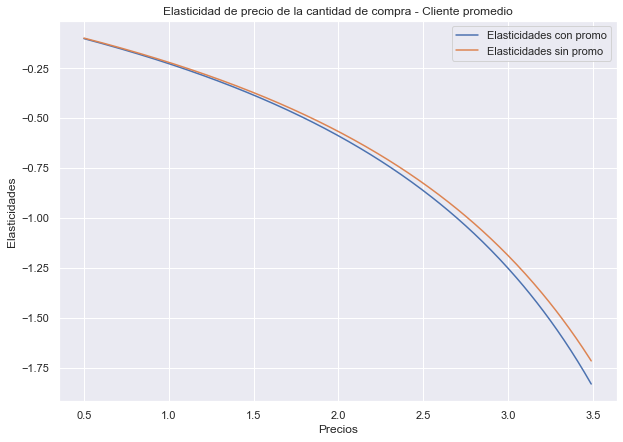

In [15]:
fig, ax = plt.subplots(figsize = (10,7))
ax.set_xlabel("Precios")
ax.set_ylabel("Elasticidades")
ax.set_title("Elasticidad de precio de la cantidad de compra - Cliente promedio")
ax.plot(master_elasticidades["precio"], master_elasticidades["pe_elasticidad_compras_con_promo"], label = "Elasticidades con promo")
ax.plot(master_elasticidades["precio"], master_elasticidades["pe_elasticidad_compras_sin_promo"], label = "Elasticidades sin promo")

plt.legend()
plt.show()

### Analisis

- Las elasticidades con promoción y sin promoción son inelásticas hasta alrededor de 2.6USD.
- Al paracer, el hecho de que los productos tengan promociones no afectaría la cantidad de compras que la persona realice -las líneas se solapan en un rango de precios grande-. Esto puede deberse a que usamos features que no sean las adecuadas para predecir las compras o bien la metología de cálculo no esta bien. Por otro lado, debemos recordar que estamos analizando al cliente promedio, tal vez analizando por segmento tendremos mayor información ya que sabemos que cada segmento se comporta de manera diferente en cuanto a las compras de barras de chocolate.

Como dijimos, podemos realizar las predicciones por segmento o también podríamos analizar las elasticidades por marca, si quisiéramos analizar la marca 5 lo que deberíamos hacer es filtrar todas las transacciones relacionadas a la marca 5, y de manera similar, para las otras marcas.